# K-means algorithm

## Unsupervised machine learning : Clustering

### Reading the data
First we need to open the file containing the data we will be working on.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

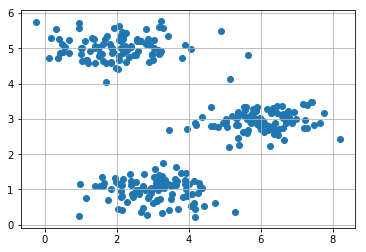

In [18]:
data = np.genfromtxt("data_kmeans.txt", delimiter=' ')

plt.scatter(data[:, 0], data[:, 1])
plt.grid()

## Clustering

### Define random starting locations

In [25]:
def initialize_cluster_centroids(data, n):
    """
    This function will return a list of n randomly initialized cluster centroids.
    """
    centroids = np.random.rand(n, data.shape[1])
    
    # We want the centroids to be initialized randomly in the range of the input data.
    # figure out the min and max on each axis
    minis = [np.min(data[:, i]) for i in range(data.shape[1])]
    maxis = [np.max(data[:, i]) for i in range(data.shape[1])]
    
    # Now we adjust centroids to be included in the same range the points are
    centroids = np.multiply(centroids, maxis)
    centroids += minis
    
    return centroids

In [26]:
cluster_centroids = initialize_cluster_centroids(data, 3)

print(cluster_centroids)

[[3.80138884 0.90461016]
 [5.77975818 2.39254549]
 [4.01520951 3.80991427]]


### For each point, find to what cluster it "belongs to"

In [33]:
def compute_distances(point, cluster_centroids):
    """
    Return a list of distances for each point 
    """
    distances = np.zeros(cluster_centroids.shape[0])
    for cluster in cluster_centroids:
        np.power(np.sum(np.power(point - cluster, 2)) , 1/2)

def return_closest(data, cluster_centroids):
    """
    Return numpy array of size equal to number of points. It indicates,
    for each point, what center that point is closest to.
    """
    proximities = np.zeros(data.shape[0])
    
    distances = np.apply_along_axis(compute_distances, 1, data, cluster_centroids)
    
    print(distances)
    
    #closest = np.argmin(distances)

In [34]:
return_closest(data, cluster_centroids)

[None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None 